# MA 641 Group 3 Project
#### Nick Gokul and Samruth
#### 7/15/22

# **California Covid 19 Cases**

## *Describe Data*

---



data:
https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a



---
## Parts of the Project
* Examine the Data
* Subset the Data
* Comapre Daily, Weekly, and Monthly
* Examine Seasonality
* Tranformations 
  - Daily
  - Weekly

In [1]:
# install packages
#%pip install pmdarima


In [2]:
# Packages
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pprint
import seaborn as sns

from IPython.display import display, HTML
from google.colab import data_table, files
#import pmdarima as pm


from matplotlib import dates as mdates

import statsmodels.api as sm
from statsmodels import tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Settings
plt.style.use('fivethirtyeight')
data_table.enable_dataframe_formatter()

In [4]:
# Functions
# Functions
def dickey_fuller_test_results(p_value):
  if p_value < 0.05:
    print(f'The null hypothesis can be rejected. The time-series is stationary. ({round(p_value, 4)} < 0.05)')
  else:
    print(f'The null hypothesis cannot be rejected. The time-series is not stationary. ({round(p_value, 4)} > 0.05)')

  return None


def find_prediction_acc(y_pred, y_true, print_result=True):

  y_pred = y_pred.reshape(-1,1)
  y_true = y_true.reshape(-1,1)
  mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true)) # Mean absolute percentage error
  mae = np.mean(np.abs(y_pred- y_true))   # mean absolute error
  mpe = np.mean((y_pred - y_true) / y_true) # Mean percentage error
  rmse = np.mean((y_pred - y_true) **2)**(1/2)  # RMSE
  corr = np.corrcoef(y_pred, y_true)[0, 1]  # Correlation Coefficient

  mins = np.amin(np.hstack([y_pred.reshape(-1,1), y_true.reshape(-1,1)]), axis=1)
  maxs = np.amax(np.hstack([y_pred.reshape(-1,1), y_true.reshape(-1,1)]), axis=1)
  minmax = 1 - np.mean(mins.reshape(-1,1) / maxs.reshape(-1,1)) # minmax
  
  accuracy_results = {
      'mape' : round(mape, 3), 'mae' :  round(mae, 3), 'mpe' : round(mpe, 3), 
      'rmse' : round(rmse, 3), 'corr' : round(corr, 3), 'minmax' :  round(minmax, 3)}

  if print_result:
    pprint.pprint(accuracy_results)
  return accuracy_results



In [5]:
# Variables
chhs_url = "https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a/download/covid19cases_test.csv"


# Load Data

In [6]:
# load data
df_chhs = pd.read_csv(chhs_url)
print('...data loaded')

...data loaded


## Observe Data

Observe orginal dataset

In [7]:
display(df_chhs.head(5))
print('tail...')
display(df_chhs.tail(5))
print()

# about the data
print('Columns:')
print(list(df_chhs.columns))
print('\nInfo:')
display(df_chhs.describe())

print('Area Type: {}'.format(df_chhs.loc[:, 'area_type'].unique()))

print('\nAreas:')
print(df_chhs.loc[:, 'area'].unique())

,date,area,area_type,population,cases,cumulative_cases,deaths,cumulative_deaths,total_tests,cumulative_total_tests,positive_tests,cumulative_positive_tests,reported_cases,cumulative_reported_cases,reported_deaths,cumulative_reported_deaths,reported_tests
0,2020-02-01,Alameda,County,1685886.0,3.0,3.0,0.0,0.0,4.0,4,0.0,0,0.0,0.0,0.0,0.0,NaN
1,2020-02-02,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,1.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
2,2020-02-03,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,0.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
3,2020-02-04,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,0.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
4,2020-02-05,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,1.0,6,0.0,0,0.0,0.0,0.0,0.0,NaN


tail...


,date,area,area_type,population,cases,cumulative_cases,deaths,cumulative_deaths,total_tests,cumulative_total_tests,positive_tests,cumulative_positive_tests,reported_cases,cumulative_reported_cases,reported_deaths,cumulative_reported_deaths,reported_tests
56176,2022-08-05,Yuba,County,79290.0,13.0,18158.0,0.0,120.0,141.0,184420,20.0,21308,0.0,18099.0,0.0,124.0,NaN
56177,2022-08-06,Yuba,County,79290.0,6.0,18164.0,0.0,120.0,51.0,184471,7.0,21315,0.0,18099.0,0.0,124.0,NaN
56178,2022-08-07,Yuba,County,79290.0,12.0,18176.0,0.0,120.0,39.0,184510,12.0,21327,0.0,18099.0,0.0,124.0,NaN
56179,2022-08-08,Yuba,County,79290.0,0.0,18176.0,0.0,120.0,NaN,184510,NaN,21327,80.0,18179.0,5.0,129.0,582.0
56180,NaN,Yuba,County,79290.0,3.0,18179.0,9.0,129.0,38.0,184548,2.0,21329,0.0,18179.0,0.0,129.0,NaN



Columns:
['date', 'area', 'area_type', 'population', 'cases', 'cumulative_cases', 'deaths', 'cumulative_deaths', 'total_tests', 'cumulative_total_tests', 'positive_tests', 'cumulative_positive_tests', 'reported_cases', 'cumulative_reported_cases', 'reported_deaths', 'cumulative_reported_deaths', 'reported_tests']

Info:


,population,cases,cumulative_cases,deaths,cumulative_deaths,total_tests,cumulative_total_tests,positive_tests,cumulative_positive_tests,reported_cases,cumulative_reported_cases,reported_deaths,cumulative_reported_deaths,reported_tests
count,5.433900e+04,55260.000000,5.526000e+04,55260.000000,55260.000000,56120.000000,5.618100e+04,56120.000000,5.618100e+04,55260.000000,5.526000e+04,55260.000000,55260.000000,4.013800e+04
mean,1.360311e+06,364.529786,1.292569e+05,3.372892,1690.041802,6433.484818,2.342986e+06,443.078795,1.542770e+05,364.529786,1.267663e+05,3.372892,1614.214911,8.920136e+03
std,5.298891e+06,2985.756798,6.738991e+05,23.094074,8242.405610,34601.015733,1.265094e+07,3701.838541,8.209052e+05,3875.331154,6.643996e+05,24.208137,7971.908413,5.502814e+04
min,1.117000e+03,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-14469.000000,0.000000e+00,-417.000000,0.000000,-2.407210e+05
25%,4.428900e+04,3.000000,7.970000e+02,0.000000,7.000000,69.000000,1.725200e+04,3.000000,8.330000e+02,0.000000,7.040000e+02,0.000000,5.000000,1.360000e+02
50%,1.930980e+05,21.000000,8.599000e+03,0.000000,102.000000,459.500000,1.517330e+05,23.000000,9.477000e+03,8.000000,8.119500e+03,0.000000,90.000000,6.850000e+02
75%,7.825450e+05,99.000000,4.408975e+04,1.000000,543.000000,2259.250000,7.861200e+05,115.000000,5.037700e+04,69.000000,4.304375e+04,0.000000,491.000000,2.854000e+03
max,4.012916e+07,156152.000000,1.007196e+07,715.000000,93193.000000,871309.000000,1.805236e+08,189977.000000,1.243279e+07,319809.000000,1.007196e+07,1178.000000,93193.000000,2.122165e+06


Area Type: ['County' 'State']

Areas:
['Alameda' 'Alpine' 'Amador' 'Butte' 'Calaveras' 'California' 'Colusa'
 'Contra Costa' 'Del Norte' 'El Dorado' 'Fresno' 'Glenn' 'Humboldt'
 'Imperial' 'Inyo' 'Kern' 'Kings' 'Lake' 'Lassen' 'Los Angeles' 'Madera'
 'Marin' 'Mariposa' 'Mendocino' 'Merced' 'Modoc' 'Mono' 'Monterey' 'Napa'
 'Nevada' 'Orange' 'Out of state' 'Placer' 'Plumas' 'Riverside'
 'Sacramento' 'San Benito' 'San Bernardino' 'San Diego' 'San Francisco'
 'San Joaquin' 'San Luis Obispo' 'San Mateo' 'Santa Barbara' 'Santa Clara'
 'Santa Cruz' 'Shasta' 'Sierra' 'Siskiyou' 'Solano' 'Sonoma' 'Stanislaus'
 'Sutter' 'Tehama' 'Trinity' 'Tulare' 'Tuolumne' 'Unknown' 'Ventura'
 'Yolo' 'Yuba']


There are two area types: County and State. Each record is has a primary key of county and date.

## Subset Data

Only want statewide data - Subset area_type to state only. This will only show California records

In [8]:
# subset data by state
df_california = df_chhs.loc[df_chhs.loc[:, 'area_type']== 'State' , :]
df_california.shape
# reset index
df_california = df_california.reset_index()
# make datetime
df_california.loc[:, "date"] = df_california.loc[:, "date"].astype("datetime64")

# Display data
print('State Dataset:')
print('head...')
display(df_california.head(5))
print('tail...')
display(df_california.tail(5))

State Dataset:
head...


,index,date,area,area_type,population,cases,cumulative_cases,deaths,cumulative_deaths,total_tests,cumulative_total_tests,positive_tests,cumulative_positive_tests,reported_cases,cumulative_reported_cases,reported_deaths,cumulative_reported_deaths,reported_tests
0,4605,2020-02-01,California,State,40129160.0,24.0,24.0,0.0,0.0,304.0,304,9.0,9,3.0,3.0,0.0,0.0,NaN
1,4606,2020-02-02,California,State,40129160.0,9.0,33.0,0.0,0.0,36.0,340,2.0,11,3.0,6.0,0.0,0.0,NaN
2,4607,2020-02-03,California,State,40129160.0,7.0,40.0,0.0,0.0,29.0,369,1.0,12,0.0,6.0,0.0,0.0,NaN
3,4608,2020-02-04,California,State,40129160.0,1.0,41.0,0.0,0.0,32.0,401,1.0,13,0.0,6.0,0.0,0.0,NaN
4,4609,2020-02-05,California,State,40129160.0,3.0,44.0,0.0,0.0,45.0,446,1.0,14,0.0,6.0,0.0,0.0,NaN


tail...


,index,date,area,area_type,population,cases,cumulative_cases,deaths,cumulative_deaths,total_tests,cumulative_total_tests,positive_tests,cumulative_positive_tests,reported_cases,cumulative_reported_cases,reported_deaths,cumulative_reported_deaths,reported_tests
916,5521,2022-08-05,California,State,40129160.0,9020.0,10066301.0,2.0,92992.0,68770.0,180381932,9424.0,12418826,0.0,10024326.0,0.0,93056.0,NaN
917,5522,2022-08-06,California,State,40129160.0,4152.0,10070453.0,0.0,92992.0,26854.0,180408786,4309.0,12423135,0.0,10024326.0,0.0,93056.0,NaN
918,5523,2022-08-07,California,State,40129160.0,985.0,10071438.0,0.0,92992.0,7474.0,180416260,1094.0,12424229,0.0,10024326.0,0.0,93056.0,NaN
919,5524,2022-08-08,California,State,40129160.0,0.0,10071438.0,0.0,92992.0,NaN,180416260,NaN,12424229,47632.0,10071958.0,137.0,93193.0,412846.0
920,5525,NaT,California,State,40129160.0,520.0,10071958.0,201.0,93193.0,107324.0,180523584,8562.0,12432791,0.0,10071958.0,0.0,93193.0,NaN


The last row is covid cases that cannot be specified to certain day. The second to last row is a filler row for the next report. These two rows can be removed

In [9]:
# remove last 2 rows - not reported
df_california.drop(df_california.tail(2).index, inplace = True)


In [10]:
print('\nInfo:')
display(df_california.describe())
print('\nKey Columns:')
display(df_california.loc[:,['date', 'population', 'cases', 'deaths', 'total_tests', 'positive_tests']].describe())


Info:


,index,population,cases,cumulative_cases,deaths,cumulative_deaths,total_tests,cumulative_total_tests,positive_tests,cumulative_positive_tests,reported_cases,cumulative_reported_cases,reported_deaths,cumulative_reported_deaths,reported_tests
count,919.000000,919.0,919.000000,9.190000e+02,919.000000,919.000000,919.000000,9.190000e+02,919.000000,9.190000e+02,919.000000,9.190000e+02,919.000000,919.000000,6.570000e+02
mean,5064.000000,40129160.0,10959.127312,3.864226e+06,101.188248,50608.998912,196318.019587,7.122383e+07,13519.291621,4.688641e+06,10907.862894,3.789346e+06,101.257889,48329.022851,2.718499e+05
std,265.436747,0.0,18777.349679,3.148920e+06,132.267745,33030.348096,156777.106066,5.956705e+07,23577.749020,3.903767e+06,25784.011246,3.127546e+06,137.946210,32643.345762,2.818302e+05
min,4605.000000,40129160.0,1.000000,2.400000e+01,0.000000,0.000000,3.000000,3.040000e+02,0.000000,9.000000e+00,-4803.000000,3.000000e+00,-352.000000,0.000000,-2.407210e+05
25%,4834.500000,40129160.0,2290.500000,7.993165e+05,25.000000,16049.500000,71423.500000,1.362149e+07,2738.000000,9.396485e+05,674.500000,7.719830e+05,3.000000,14694.500000,1.183210e+05
50%,5064.000000,40129160.0,5160.000000,3.675309e+06,67.000000,62839.000000,158611.000000,6.215341e+07,6242.000000,4.374969e+06,3447.000000,3.648276e+06,63.000000,60927.000000,1.893190e+05
75%,5293.500000,40129160.0,11293.500000,5.034960e+06,112.500000,77322.500000,294415.000000,1.191671e+08,13888.500000,6.093714e+06,9543.000000,4.948678e+06,135.500000,75224.000000,2.964240e+05
max,5523.000000,40129160.0,156152.000000,1.007144e+07,715.000000,92992.000000,871309.000000,1.804163e+08,189977.000000,1.242423e+07,319809.000000,1.002433e+07,1178.000000,93056.000000,2.122165e+06



Key Columns:


,population,cases,deaths,total_tests,positive_tests
count,919.0,919.000000,919.000000,919.000000,919.000000
mean,40129160.0,10959.127312,101.188248,196318.019587,13519.291621
std,0.0,18777.349679,132.267745,156777.106066,23577.749020
min,40129160.0,1.000000,0.000000,3.000000,0.000000
25%,40129160.0,2290.500000,25.000000,71423.500000,2738.000000
50%,40129160.0,5160.000000,67.000000,158611.000000,6242.000000
75%,40129160.0,11293.500000,112.500000,294415.000000,13888.500000
max,40129160.0,156152.000000,715.000000,871309.000000,189977.000000


In [11]:
# Keep only Date and Columns
df_cal_cases = df_california.loc[:, ['date', 'cases']]

# Plots and Transformations

## Daily, Weekly, and Monthly Data

In [12]:
# Daily Cases
data_daily = df_cal_cases.copy().set_index(['date'])
print('Daily Cases:')
display(data_daily.tail(5))

# Weekly Cases
data_weekly = data_daily.copy().reset_index()
data_weekly['date'] = data_weekly['date'] - pd.to_timedelta(7, unit='d')
data_weekly = data_weekly.groupby([ pd.Grouper(key='date', freq='W-MON')])['cases'].sum().reset_index().sort_values('date')
data_weekly = data_weekly.set_index(['date'])
print('Weekly Cases:')
display(data_weekly.tail(5))

# Monthly Cases
data_monthly = data_daily.copy()
data_monthly['year'] = data_monthly.index.year
data_monthly['month'] = data_monthly.index.month
data_monthly = data_monthly.groupby(['year', 'month']).sum()
print('Monthly Cases:')
display(data_monthly.head(5))
data_monthly = data_monthly.reset_index()

# covert month and date to first month of every year
data_monthly1 =  data_monthly.set_index(pd.to_datetime(data_monthly[['year','month']].assign(day=1))).loc[:,'cases']


Daily Cases:


,cases
date,
2022-08-03,11936.0
2022-08-04,10116.0
2022-08-05,9020.0
2022-08-06,4152.0
2022-08-07,985.0


Weekly Cases:


,cases
date,
2022-07-04,139924.0
2022-07-11,128048.0
2022-07-18,116567.0
2022-07-25,94669.0
2022-08-01,50272.0


Monthly Cases:


cases
year month          
2020 2         472.0
     3       19291.0
     4       46521.0
     5       71095.0
     6      173939.0

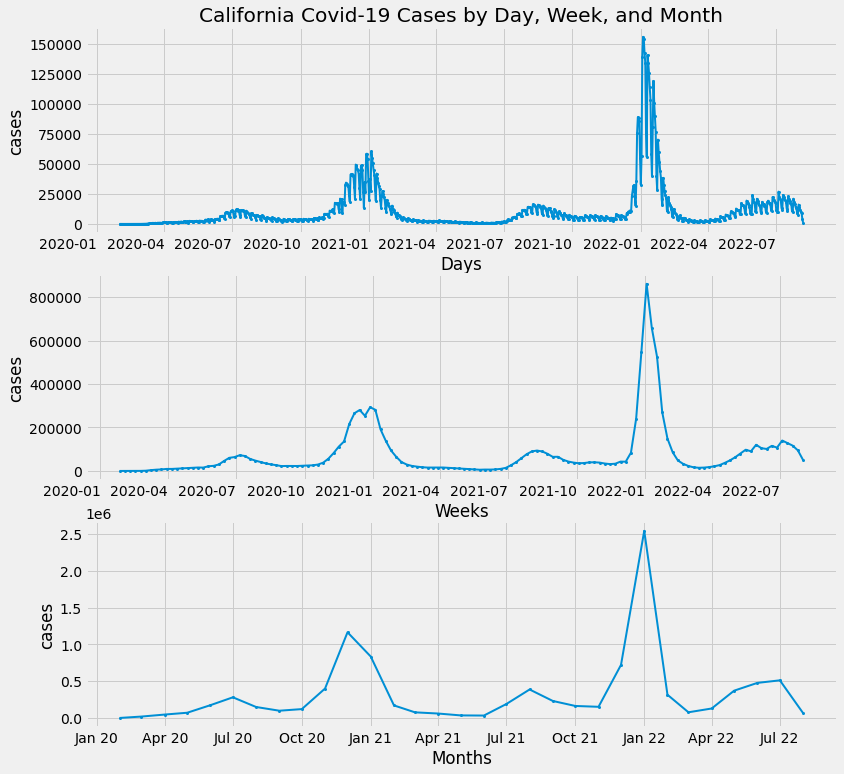

In [13]:
# Plot Daily, Monthly, and Weekly
from matplotlib import dates as mdates

plt.figure(figsize=(12, 12))


# Daily Plot
plt.subplot(3,1, 1)
#plt.figure(figsize= ts_fig_size, dpi=80)
plt.plot(data_daily, marker='o', linewidth= 2, markersize=2)
plt.xticks(rotation=0, ha='right')
plt.title('California Covid-19 Cases by Day, Week, and Month')
plt.xlabel('Days')
plt.ylabel('cases')
#plt.show()

# Weekly Plot
plt.subplot(3,1, 2)
plt.plot(data_weekly, marker='o', linewidth= 2, markersize=2)
plt.xticks(rotation=0, ha='right')
#plt.title('California Covid-19 Cases by Week')
plt.xlabel('Weeks')
plt.ylabel('cases')
#plt.show()

# Monthly Plot
s = plt.subplot(3,1, 3)
s.plot(data_monthly1, marker='o', linewidth= 2, markersize=2)
s.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.xlabel('Months')
plt.ylabel('cases')

plt.show()

The data will remain as days in order to keep a large sample size.

### Season Decomposition

In [14]:
# Set data
data = data_daily.copy()

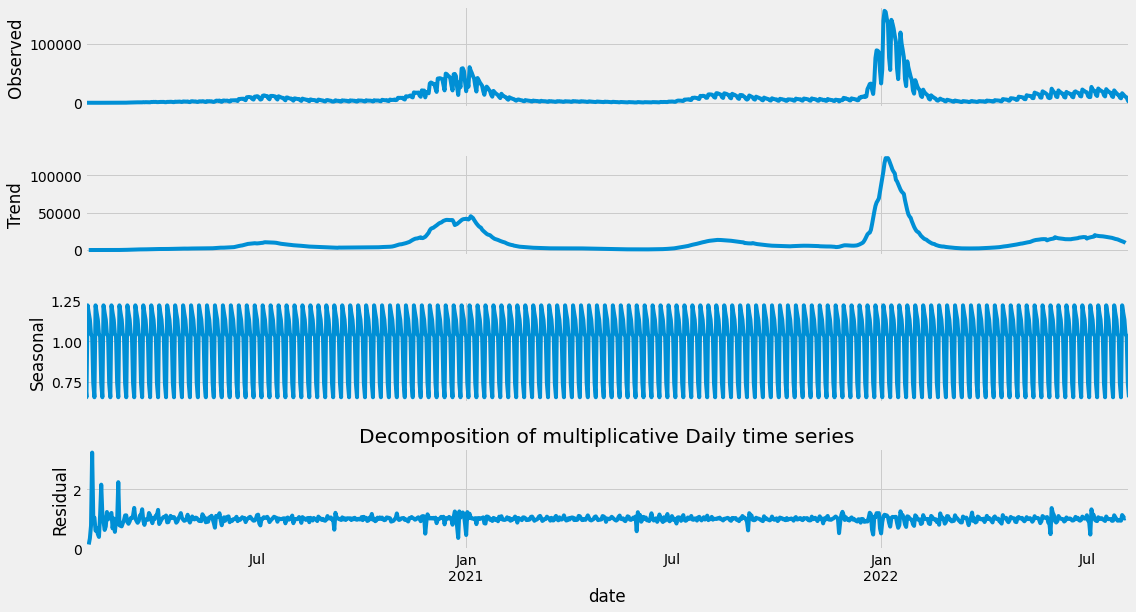

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

model_type = 'multiplicative' # additive, multiplicative
data_season_breakdown = data.copy() + 1

result = seasonal_decompose(data_season_breakdown, model=model_type)
fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.title(f'Decomposition of {model_type} Daily time series')
plt.show()

There really is no over arching trend. There may be sesonalilty in the dataset

### Weekly Seasonlity Decomposition
Group data by week and test seasonality

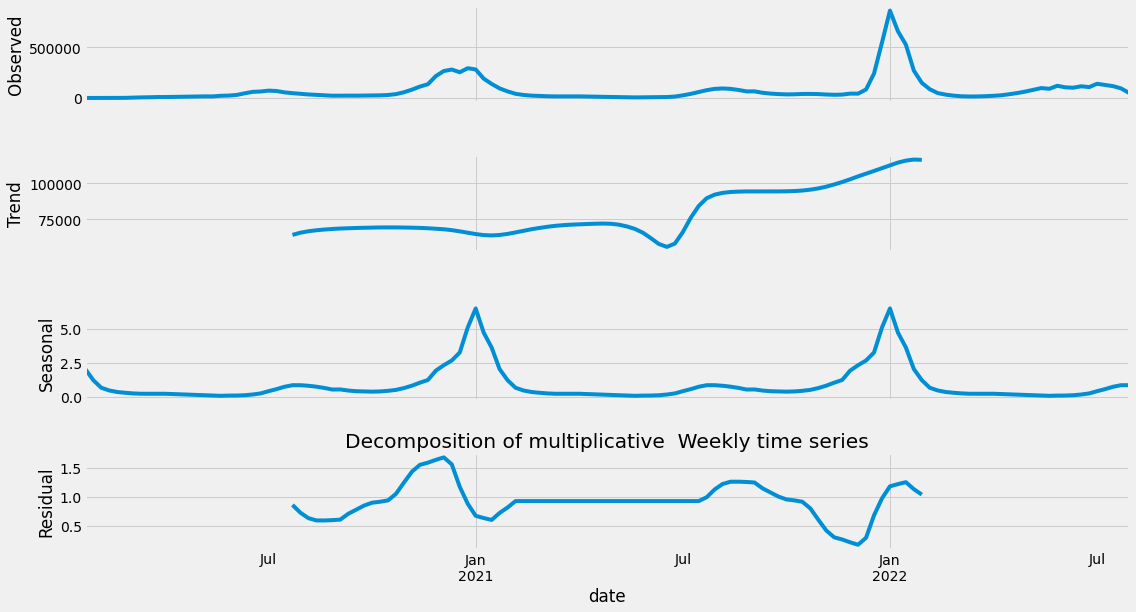

In [16]:
data = data_weekly.copy()

model_type = 'multiplicative' # additive, multiplicative
data_season_breakdown = data.copy() + 1


result = seasonal_decompose(data_season_breakdown, model=model_type)

fig = result.plot()
plt.title(f'Decomposition of {model_type}  Weekly time series')
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

# Data Tranformations


In [17]:
# Variables

# figure size
ts_fig_size = (10, 4)
acf_pacf_fig_size = (12,4)

# stationary p-value data frame
stationary_pvalue_map = {'Transformation' : [], 'Pvalue' : []}

# Functions
def covid_plot_ts_acf_pacf(data, tranformation_type, x_label_name, y_label_name, data_type_name= 'Daily', color_plot = '#30a2da'):
  '''
  Plot Time Series ACF and PCF
  '''
  #Plot Time Series
  plt.figure(figsize= ts_fig_size, dpi=80)
  plt.plot( data, marker='o', markersize=2, linewidth=2, color=color_plot)
  plt.title(f'California {data_type_name} Covid-19 Cases {tranformation_type}')
  plt.xticks(rotation=45, ha='right')
  plt.xlabel(x_label_name)
  plt.ylabel(y_label_name)
  plt.show()


  # acf pacf plts
  fig, ax = plt.subplots(1,2,figsize= acf_pacf_fig_size)
  # acf
  sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=40, ax=ax[0], color=color_plot)
  #sm.graphics.tsa.plot_acf(data.values.squeeze(), ax=ax[0], color=color_plot)
  # pacf
  sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax[1], color=color_plot)
  #sm.graphics.tsa.plot_pacf(data, ax=ax[1], color=color_plot)
    
  plt.show()
  return None



## Daily Data

In [18]:
# data information
data_type_name = 'Daily'
x_label_name = 'Days'
data = data_daily.copy()


#### No Tranformation - Daily

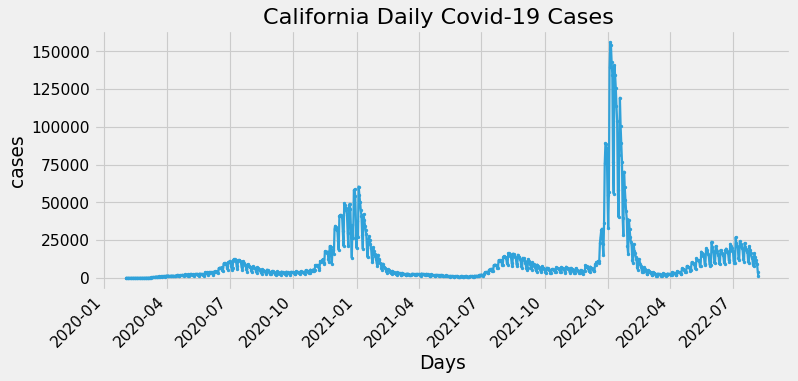

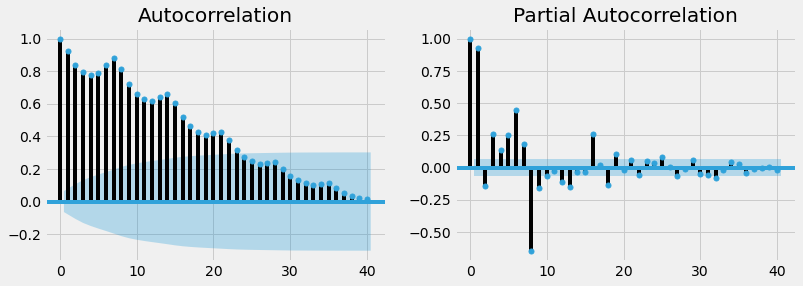


Dickey-Fuller test:
(-4.2961272305696, 0.00045112216482982105, 18, 900, {'1%': -3.43763672130727, '5%': -2.864756726529493, '10%': -2.568482801234568}, 17551.240094545232)
p-value: 0.00045112216482982105


In [19]:
# No Tranformation
# plot information
data_plot = data.loc[:, 'cases']
tranformation_type = ''
y_label_name = 'cases'
color_plot = '#30a2da' #'mediumorchid'

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {result[1]}')
stationary_pvalue_map['Transformation'].append(f'{data_type_name} {tranformation_type}')
stationary_pvalue_map['Pvalue'].append(result[1])


There are no noticable trends in the the Time-Series except for one section. There is a sharp decay in the ACF and noticble lags in the PACF. It seems like this is a pure AR Model.

### Stationary Transformations
### Log Transformation - Daily

In [20]:
# Log Transformation
data.loc[:, "log_cases"] = (data.loc[:, 'cases'] + 1).apply(np.log)


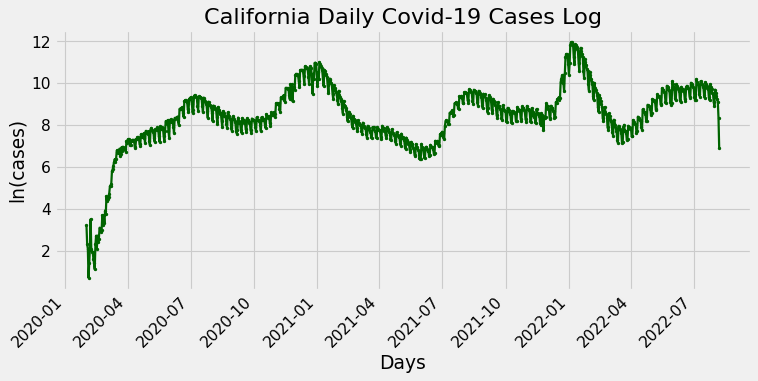

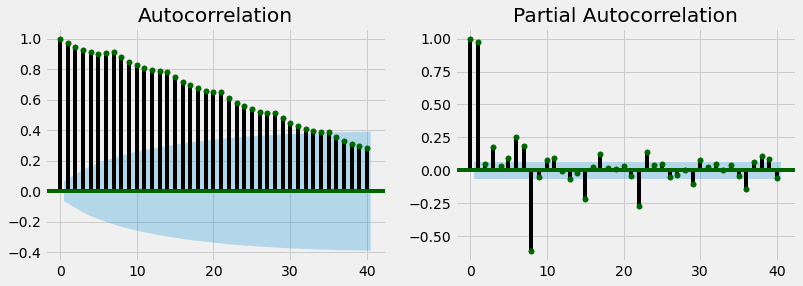


Dickey-Fuller test:
(-4.716090935151022, 7.84867195939539e-05, 21, 897, {'1%': -3.4376611618861697, '5%': -2.864767502722044, '10%': -2.5684885413039127}, -707.8634416122025)
p-value: 7.84867195939539e-05


In [21]:
# plot information
data_plot = data["log_cases"]
tranformation_type = 'Log'
y_label_name = 'ln(cases)'
color_plot = 'darkgreen' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {result[1]}')
stationary_pvalue_map['Transformation'].append(f'{data_type_name} {tranformation_type}')
stationary_pvalue_map['Pvalue'].append(result[1])

### Differencing (1) - Daily

In [22]:
data.loc[:, "cases_diff1"] = (data.loc[:, 'cases']).diff(1)
# drop first row for differencing
data_diff1 = data.copy().loc[:, ['cases_diff1']].iloc[1:, :]

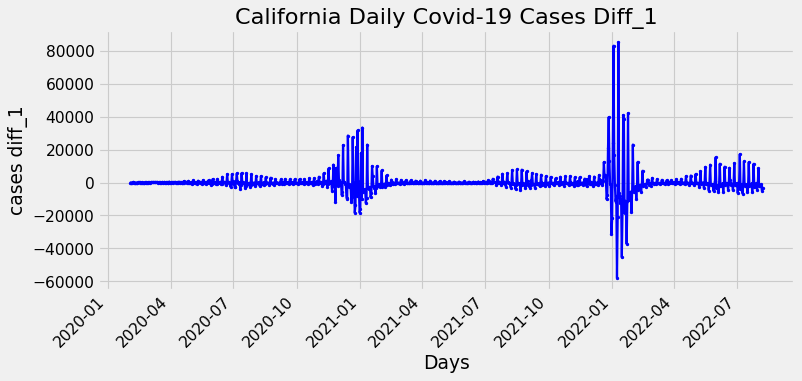

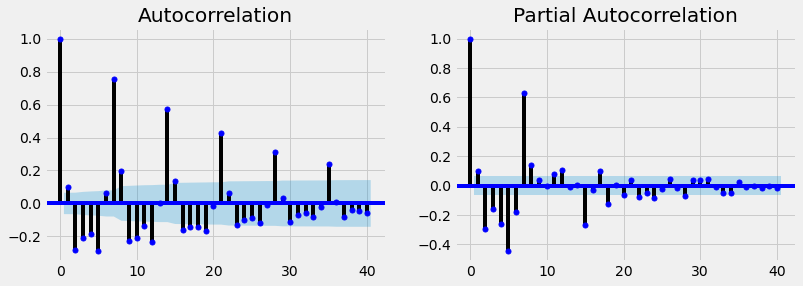


Dickey-Fuller test:
(-6.670612225915208, 4.598003612090322e-09, 21, 896, {'1%': -3.4376693452209492, '5%': -2.864771110849186, '10%': -2.5684904632194674}, 17546.18745589133)
p-value: 4.598003612090322e-09


In [23]:
# plot information
data_plot = data_diff1["cases_diff1"]
tranformation_type = 'Diff_1'
y_label_name = 'cases diff_1'
color_plot = 'blue' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {result[1]}')
stationary_pvalue_map['Transformation'].append(f'{data_type_name} {tranformation_type}')
stationary_pvalue_map['Pvalue'].append(result[1])

### Log Tranformation + Differencing 1 - Daily

In [24]:
# Transform Data
data.loc[:, 'cases_log_diff1'] = data.loc[:, "log_cases"].diff(1)
display(data.head())
# drop first row for differencing
data_log_diff1 = data.copy().loc[:, [ 'cases_log_diff1']].iloc[1:, :]

,cases,log_cases,cases_diff1,cases_log_diff1
date,,,,
2020-02-01,24.0,3.218876,NaN,NaN
2020-02-02,9.0,2.302585,-15.0,-0.916291
2020-02-03,7.0,2.079442,-2.0,-0.223144
2020-02-04,1.0,0.693147,-6.0,-1.386294
2020-02-05,3.0,1.386294,2.0,0.693147


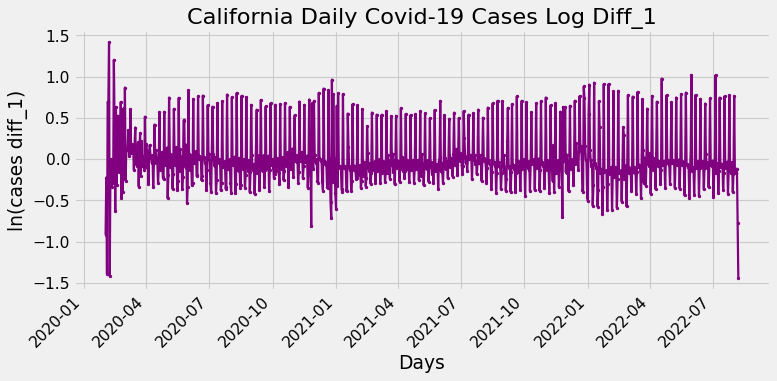

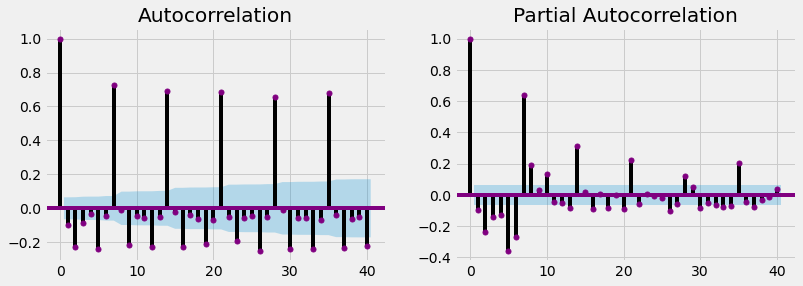


Dickey-Fuller test:
(-3.2038739565832723, 0.01976153163970215, 21, 896, {'1%': -3.4376693452209492, '5%': -2.864771110849186, '10%': -2.5684904632194674}, -694.762912585602)
p-value: 0.01976153163970215


In [25]:
# plot information
data_plot = data_log_diff1["cases_log_diff1"]
tranformation_type = 'Log Diff_1'
y_label_name = 'ln(cases diff_1)'
color_plot = 'purple' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {result[1]}')
stationary_pvalue_map['Transformation'].append(f'{data_type_name} {tranformation_type}')
stationary_pvalue_map['Pvalue'].append(result[1])

### Seasonal Transfromation - Daily

In [26]:
season_len = 365
data_seasondiff = data.loc[:, ['cases']].diff(season_len).iloc[season_len:, :]

display( data_seasondiff.head(5))

,cases
date,
2021-01-31,7964.0
2021-02-01,15299.0
2021-02-02,12628.0
2021-02-03,11532.0
2021-02-04,10152.0


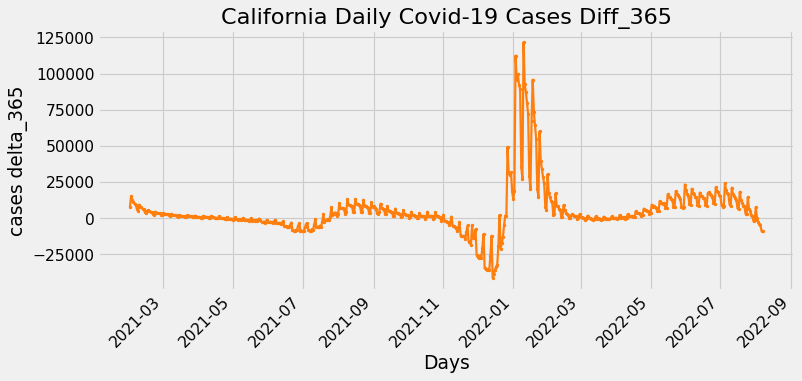

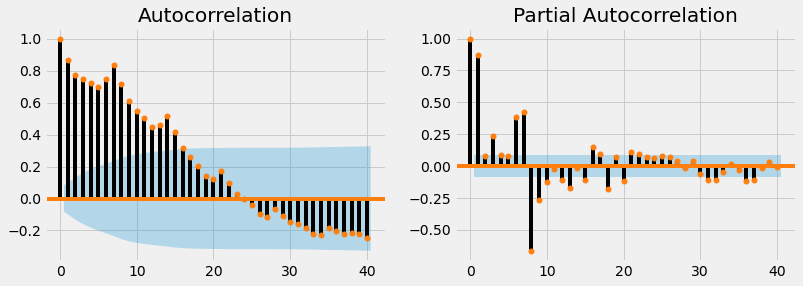


Dickey-Fuller test:
(-5.16188936292089, 1.0511772341230062e-05, 19, 534, {'1%': -3.4426552678216003, '5%': -2.8669676577777548, '10%': -2.569660749624767}, 10640.504046701824)
p-value: 1.0511772341230062e-05


In [27]:
# plot information
data_plot = data_seasondiff["cases"]
tranformation_type = f'Diff_{season_len}'
y_label_name = f'cases delta_{season_len}'
color_plot = 'tab:orange' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {result[1]}')
stationary_pvalue_map['Transformation'].append(f'{data_type_name} {tranformation_type}')
stationary_pvalue_map['Pvalue'].append(result[1])

#### Augmented Dickey-Fuller Test - Daily
p-value of each transformation

In [28]:
df_stationary_pval = pd.DataFrame(stationary_pvalue_map)
display(df_stationary_pval)

,Transformation,Pvalue
0,Daily,4.511222e-04
1,Daily Log,7.848672e-05
2,Daily Diff_1,4.598004e-09
3,Daily Log Diff_1,1.976153e-02
4,Daily Diff_365,1.051177e-05


The data appears to already be stationary so there is no need to do any transformations



---



---



---



---



# Weekly Data 
## Describe and Plot

In [29]:
# data information
data_type_name = 'Weekly'
x_label_name = 'Weeks'
data = data_weekly.copy()

# stationary p-value data frame
#stationary_pvalue_map = {'Transformation' : [], 'Pvalue' : []}

In [30]:
data.describe()

,cases
count,132.000000
mean,76298.772727
std,122321.350968
min,40.000000
25%,15788.000000
50%,37633.000000
75%,84520.750000
max,861015.000000


### No Tranformation - Weekly

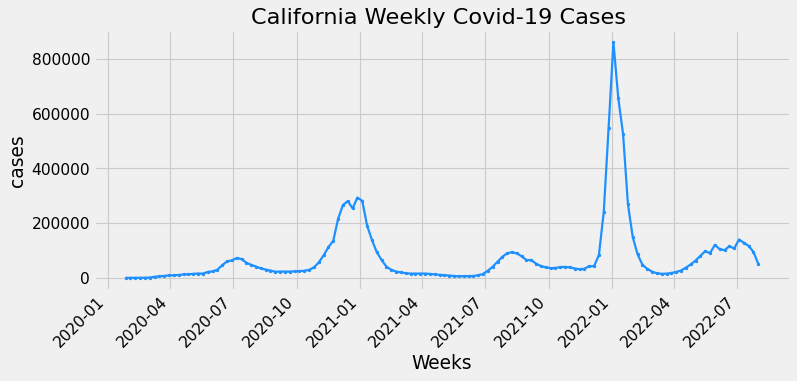

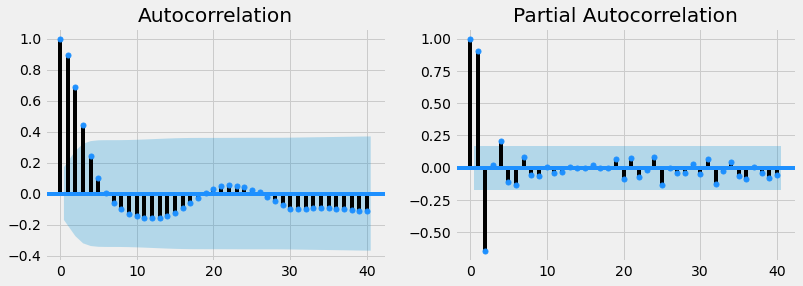


Dickey-Fuller test:
(-5.169146326530755, 1.0161005176279456e-05, 1, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 2869.357715975862)
p-value: 1.0161005176279456e-05
The null hypothesis can be rejected. The time-series is stationary. (0.0 < 0.05)


In [31]:
# plot information
data_plot = data["cases"]
tranformation_type = ''
y_label_name = 'cases'
color_plot = 'dodgerblue' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {result[1]}')
dickey_fuller_test_results(result[1])
stationary_pvalue_map['Transformation'].append(f'{data_type_name} {tranformation_type}')
stationary_pvalue_map['Pvalue'].append(result[1])

The weekly data has significant lags and 1 and 2 in hte pACF

### Stationary Transformations
#### Log Transformation - Weekly

In [32]:
# Log Transformation
data.loc[:, "log_cases"] = (data.loc[:, 'cases'] + 1).apply(np.log)


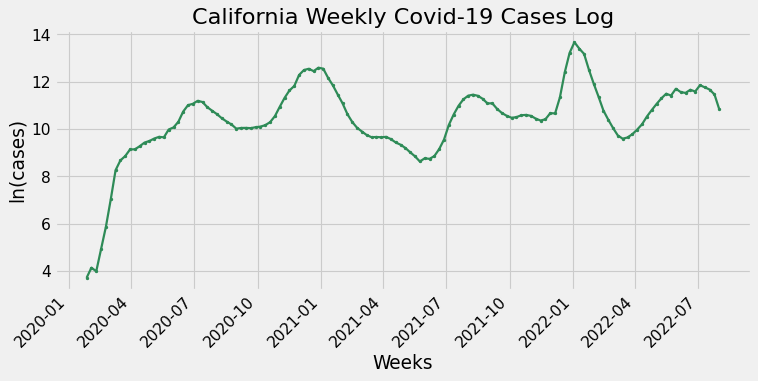

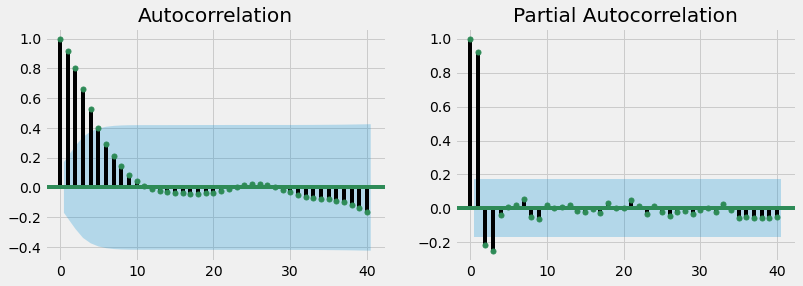


Dickey-Fuller test:
(-6.508267300074895, 1.1169642031358285e-08, 2, 129, {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}, -85.89714700263704)
p-value: 1.1169642031358285e-08
The null hypothesis can be rejected. The time-series is stationary. (0.0 < 0.05)


In [33]:
# plot information
data_plot = data["log_cases"]
tranformation_type = 'Log'
y_label_name = 'ln(cases)'
color_plot = 'seagreen' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {result[1]}')
dickey_fuller_test_results(result[1])
stationary_pvalue_map['Transformation'].append(f'{data_type_name} {tranformation_type}')
stationary_pvalue_map['Pvalue'].append(result[1])

### Differencing (1) - Weekly

In [34]:
data.loc[:, "cases_diff1"] = (data.loc[:, 'cases']).diff(1)
# drop first row for differencing
data_diff1 = data.copy().loc[:, ['cases_diff1']].iloc[1:, :]

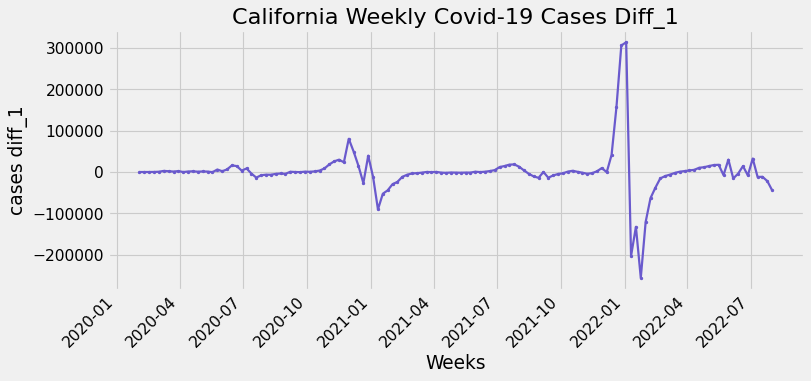

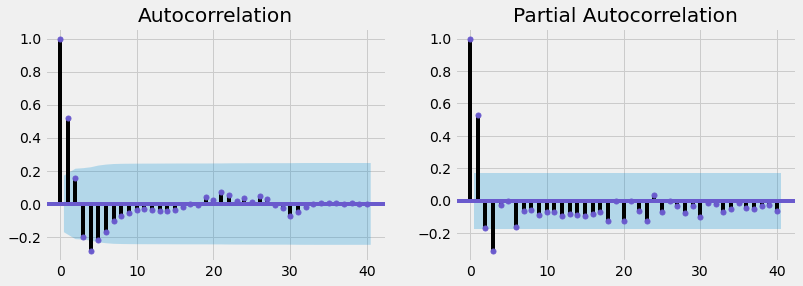


Dickey-Fuller test:
(-7.541012289474828, 3.3781691425025166e-11, 2, 128, {'1%': -3.4825006939887997, '5%': -2.884397984161377, '10%': -2.578960197753906}, 2857.091514144047)
p-value: 3.3781691425025166e-11
The null hypothesis can be rejected. The time-series is stationary. (0.0 < 0.05)


In [35]:
# First Difference Weekly

# plot information
data_plot = data_diff1["cases_diff1"]
tranformation_type = 'Diff_1'
y_label_name = 'cases diff_1'
color_plot = 'slateblue' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {result[1]}')
dickey_fuller_test_results(result[1])
stationary_pvalue_map['Transformation'].append(f'{data_type_name} {tranformation_type}')
stationary_pvalue_map['Pvalue'].append(result[1])

### Log Tranformation + Differencing 1 - Weekly

In [36]:
# Transform Data
data.loc[:, 'cases_log_diff1'] = data.loc[:, "log_cases"].diff(1)
display(data.head())
# drop first row for differencing
data_log_diff1 = data.copy().loc[:, ['cases_log_diff1']].iloc[1:, :]

,cases,log_cases,cases_diff1,cases_log_diff1
date,,,,
2020-01-27,40.0,3.713572,NaN,NaN
2020-02-03,62.0,4.143135,22.0,0.429563
2020-02-10,53.0,3.988984,-9.0,-0.154151
2020-02-17,138.0,4.934474,85.0,0.945490
2020-02-24,354.0,5.872118,216.0,0.937644


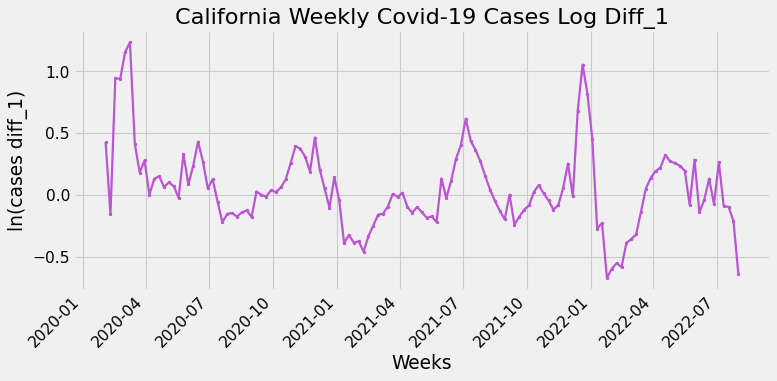

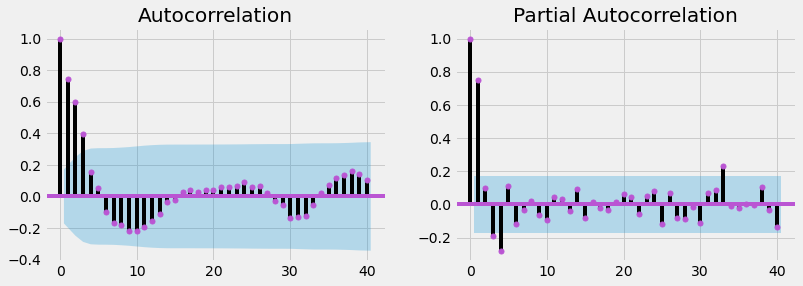


Dickey-Fuller test:
(-5.148717371887703, 1.1178606708536912e-05, 5, 125, {'1%': -3.4837793736959997, '5%': -2.88495387648, '10%': -2.579256976}, -73.93370152829507)
p-value: 1.1178606708536912e-05
The null hypothesis can be rejected. The time-series is stationary. (0.0 < 0.05)


In [37]:
# Weekly Log Diff1

# plot information
data_plot = data_log_diff1["cases_log_diff1"]
tranformation_type = 'Log Diff_1'
y_label_name = 'ln(cases diff_1)'
color_plot = 'mediumorchid' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {result[1]}')
dickey_fuller_test_results(result[1])
stationary_pvalue_map['Transformation'].append(f'{data_type_name} {tranformation_type}')
stationary_pvalue_map['Pvalue'].append(result[1])

### Seasonal Difference Weekly

In [38]:
season_len = 52
data_seasondiff = data.loc[:, ['cases']].diff(season_len).iloc[season_len:, :]

display( data_seasondiff.head(5))

,cases
date,
2021-01-25,94314.0
2021-02-01,64972.0
2021-02-08,41200.0
2021-02-15,29499.0
2021-02-22,22826.0


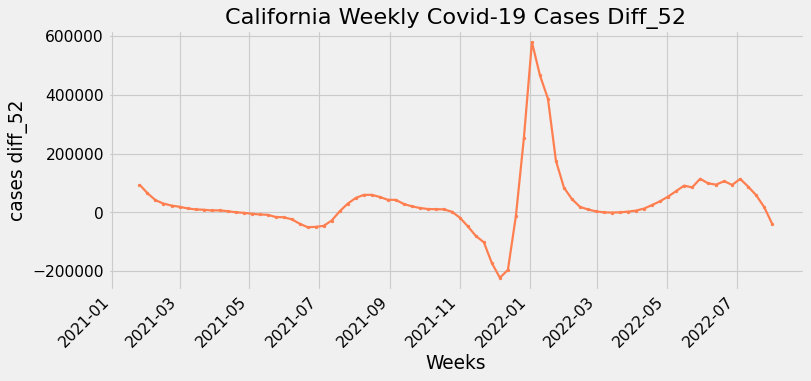

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


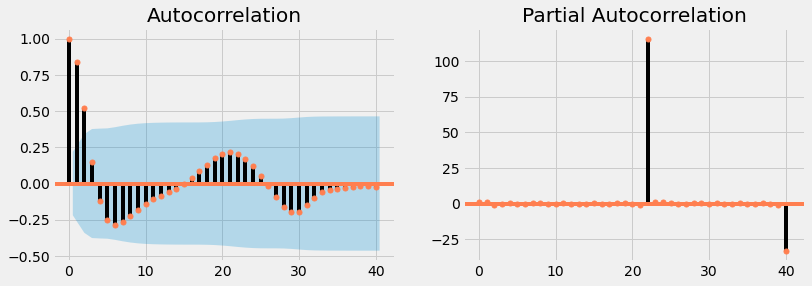


Dickey-Fuller test:
(-4.017314271258361, 0.0013225135180244783, 5, 74, {'1%': -3.5219803175527606, '5%': -2.9014701097664504, '10%': -2.58807215485756}, 1635.3139410880142)
p-value: 0.0013225135180244783
The null hypothesis can be rejected. The time-series is stationary. (0.0013 < 0.05)


In [39]:
# First Seasonal Difference

# plot information
data_plot = data_seasondiff["cases"]
tranformation_type = f'Diff_{season_len}'
y_label_name = f'cases diff_{season_len}'
color_plot = 'coral' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {result[1]}')
dickey_fuller_test_results(result[1])
stationary_pvalue_map['Transformation'].append(f'{data_type_name} {tranformation_type}')
stationary_pvalue_map['Pvalue'].append(result[1])

#### Augmented Dickey-Fuller Test - Weekly
p-value of each transformation

In [40]:
df_stationary_pval = pd.DataFrame(stationary_pvalue_map)
display(df_stationary_pval)
display(df_stationary_pval.loc[df_stationary_pval['Transformation'].str.contains('Weekly'), :])

,Transformation,Pvalue
0,Daily,4.511222e-04
1,Daily Log,7.848672e-05
2,Daily Diff_1,4.598004e-09
3,Daily Log Diff_1,1.976153e-02
4,Daily Diff_365,1.051177e-05
5,Weekly,1.016101e-05
6,Weekly Log,1.116964e-08
7,Weekly Diff_1,3.378169e-11
8,Weekly Log Diff_1,1.117861e-05
9,Weekly Diff_52,1.322514e-03


,Transformation,Pvalue
5,Weekly,1.016101e-05
6,Weekly Log,1.116964e-08
7,Weekly Diff_1,3.378169e-11
8,Weekly Log Diff_1,1.117861e-05
9,Weekly Diff_52,1.322514e-03


The data appears to already be stationary so there is no need to do any transformations